Projekat 3

Filip Nikolić   
Jovan Dimitrijević

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import matplotlib.pyplot as plt
# Keras Tuner za optimizaciju hiperparametara
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

/Users/filipnikolic/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_34647/2721180220.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


Priprema i predobrada dataseta

In [2]:
# Učitavanje i čišćenje podataka
data = pd.read_csv('air traffic.csv')

# Konvertovanje stringova u float vrednosti i obrada outlier-a
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace(',', '').astype(float)

# Identifikacija i uklanjanje outlier-a pomoću Z-score
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
data_clean = data[(z_scores < 3).all(axis=1)]

X = data_clean.drop(['Dom_LF', 'Int_LF', 'LF'], axis=1).values
y = data_clean[['Dom_LF', 'Int_LF', 'LF']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizacija podataka
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Kreiranje neuronske mreže

In [3]:
class MyFlexibleHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        # First layer with input shape
        model.add(Dense(units=hp.Int('units_input', min_value=8, max_value=512, step=8),
                        activation=hp.Choice('activation_input', ['relu', 'tanh', 'sigmoid']),
                        input_shape=(self.input_shape,)))
        # BatchNormalization layer optional
        if hp.Boolean('batch_normalization_input'):
            model.add(BatchNormalization())
        
        # Additional layers
        for i in range(hp.Int('layers', 1, 5)):  # Flexible number of layers
            model.add(Dense(units=hp.Int(f'units_{i}', 8, 512, step=8),
                            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh', 'sigmoid']),
                            kernel_regularizer=regularizers.l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
            if hp.Boolean(f'batch_normalization_{i}'):
                model.add(BatchNormalization())
            model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.05)))
        
        # Output layer
        model.add(Dense(3, activation='linear'))  # Assuming regression problem with 3 outputs
        # Optimizer choice
        optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
        if optimizer_choice == 'adam':
            optimizer = Adam(learning_rate=hp.Float('lr_adam', 1e-4, 1e-2, sampling='log'))
        elif optimizer_choice == 'sgd':
            optimizer = SGD(learning_rate=hp.Float('lr_sgd', 1e-4, 1e-2, sampling='log'),
                            momentum=hp.Float('momentum_sgd', 0.0, 0.9, step=0.1))
        elif optimizer_choice == 'rmsprop':
            optimizer = RMSprop(learning_rate=hp.Float('lr_rmsprop', 1e-4, 1e-2, sampling='log'))
        
        # Loss function choice
        loss_choice = hp.Choice('loss_function', ['mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error'])
        
        model.compile(optimizer=optimizer, loss=loss_choice)
        return model

hypermodel = MyFlexibleHyperModel(input_shape=X_train_scaled.shape[1])

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir_new',
    project_name='air_traffic_new'
)

tuner.search(X_train_scaled, y_train, epochs=200, validation_split=0.2)

Trial 10 Complete [00h 00m 17s]
val_loss: 0.6880806386470795

Best val_loss So Far: 0.0016126921400427818
Total elapsed time: 00h 03m 19s


Vizuelizacija rezultata (najboljeg modela)

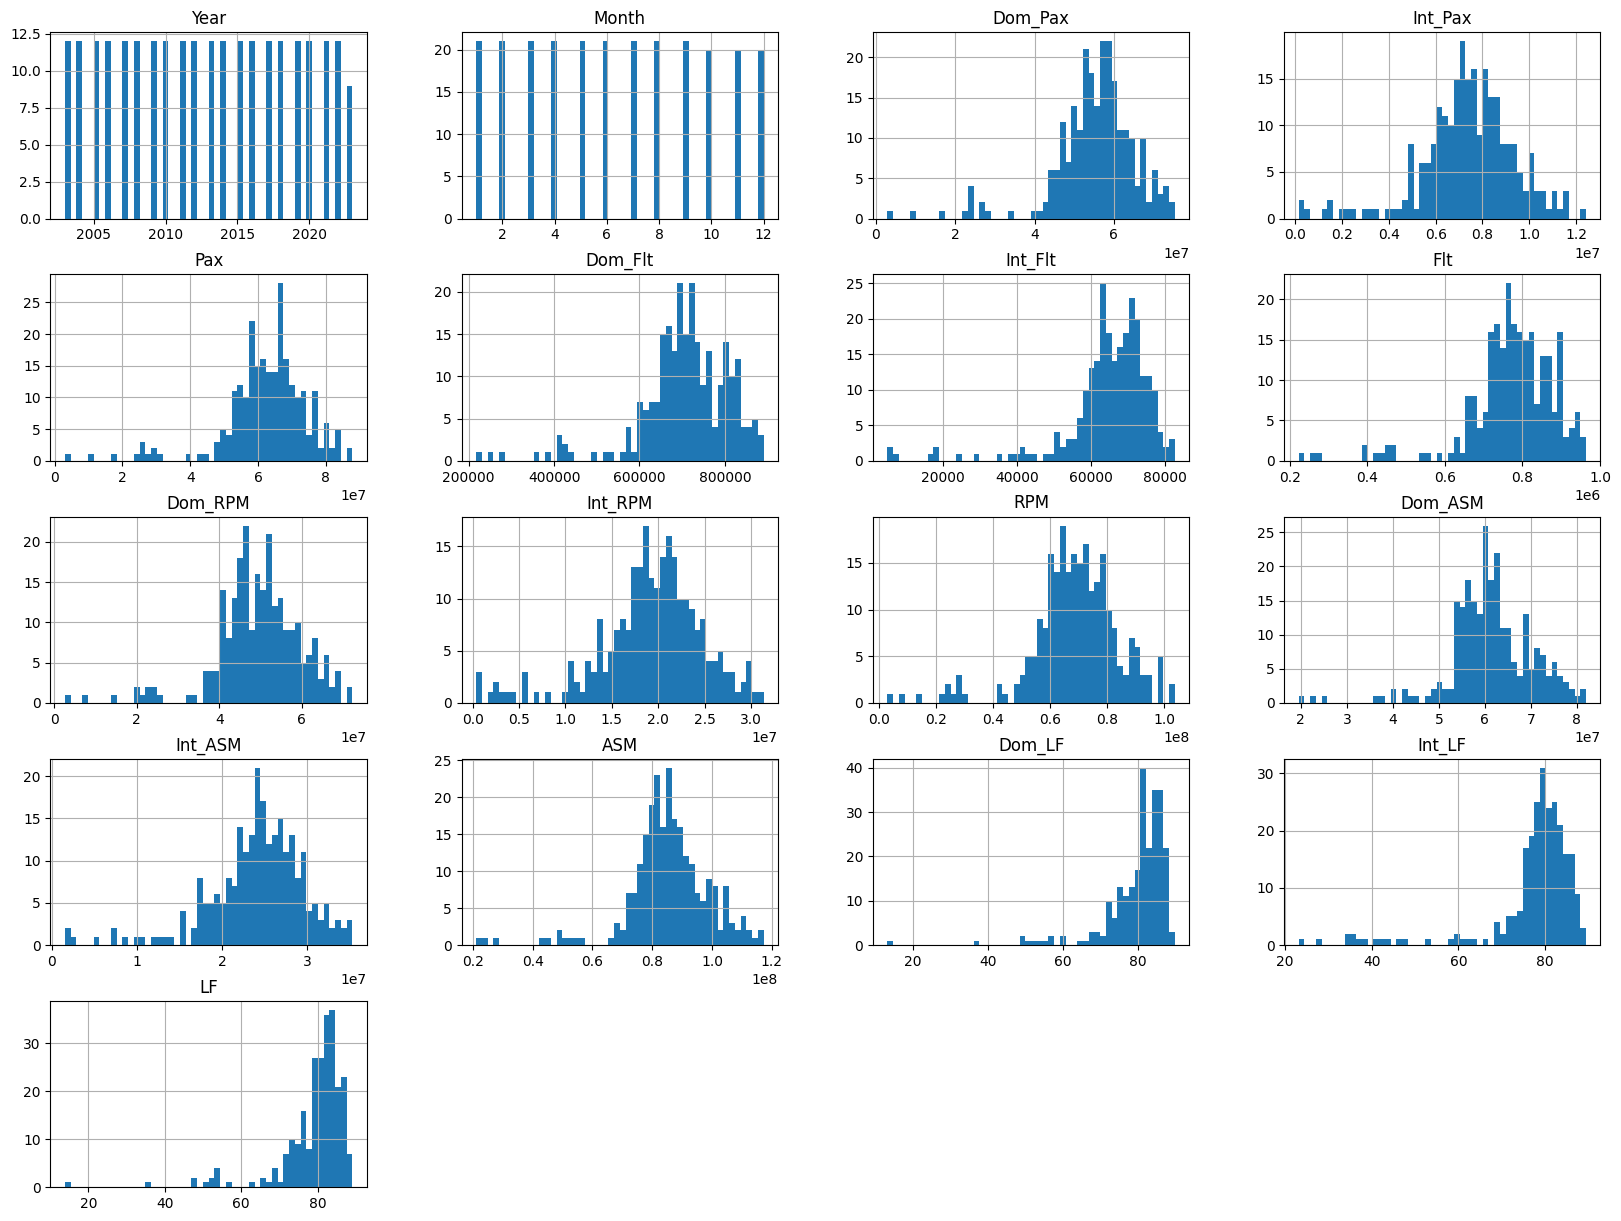

2/2 [==============================] - 0s 2ms/step
Mean Squared Error: 8.56935748288132
R2 Score: 0.7995197412290919
Mean Absolute Error: 1.8396399879455558
Root Mean Squared Error: 2.9273464917705456


In [4]:
# Najbolji model
best_model = tuner.get_best_models(num_models=1)[0]

# Vizualizacija raspodele vrednosti feature-a
data.hist(bins=50, figsize=(20,15))
plt.show()

# Evaluacija najboljeg modela
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Vizualizacija feature importance-a i prikaz najboljih hiperparametara

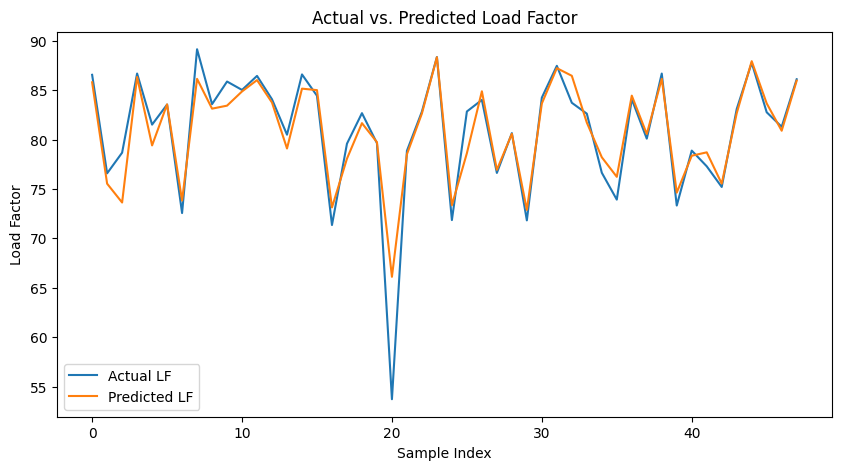

Best hyperparameters:
units_input: 288
activation_input: sigmoid
batch_normalization_input: False
layers: 1
units_0: 408
activation_0: sigmoid
l2: 0.00033312898688819126
batch_normalization_0: False
dropout_0: 0.25
optimizer: rmsprop
lr_adam: 0.000137301149750673
loss_function: mean_squared_logarithmic_error
lr_sgd: 0.0075192820434624935
momentum_sgd: 0.1
units_1: 96
activation_1: relu
batch_normalization_1: True
dropout_1: 0.35000000000000003
units_2: 88
activation_2: tanh
batch_normalization_2: True
dropout_2: 0.25
units_3: 360
activation_3: tanh
batch_normalization_3: False
dropout_3: 0.05
lr_rmsprop: 0.0018054519740046478


In [5]:
plt.figure(figsize=(10, 5))
plt.plot(y_test[:, 2], label='Actual LF')
plt.plot(y_pred[:, 2], label='Predicted LF')
plt.title('Actual vs. Predicted Load Factor')
plt.xlabel('Sample Index')
plt.ylabel('Load Factor')
plt.legend()
plt.show()

best_hp = tuner.get_best_hyperparameters()[0]

# Ispisivanje najboljih hiperparametara
print("Best hyperparameters:")
for param in best_hp.space:
    print(f"{param.name}: {best_hp.get(param.name)}")

Treniranje najboljeg modela

Epoch 1/200
5/5 [==============================] - 1s 33ms/step - loss: 0.0034 - val_loss: 0.0056
Epoch 2/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 3/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 5/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 6/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 7/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 8/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0112
Epoch 9/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 10/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 11/200
5/5 [=========

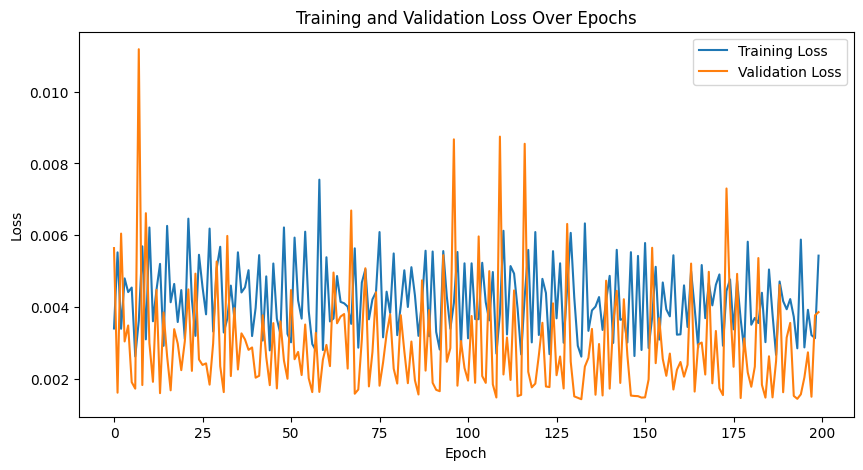

In [6]:
# Ponovo treniramo najbolji model, ovaj put čuvamo istoriju
history = best_model.fit(X_train_scaled, y_train, epochs=200, validation_split=0.2, verbose=1)

# Vizualizacija funkcije gubitka
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()